In [22]:
from IPython.display import FileLink
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [18]:
%%R
library(dplyr); library(tidyr)
library(magrittr)
library(ggplot2)
library(phyloseq)
library(DESeq2)

In [3]:
%%R
FDR = 0.10

rspndrs = read.csv("../data/l2fc_table.csv", stringsAsFactors = FALSE) %>%
    filter(test == "greater", p.adj <= FDR) %>%
    select(OTU) %>% extract2(1) %>% unique

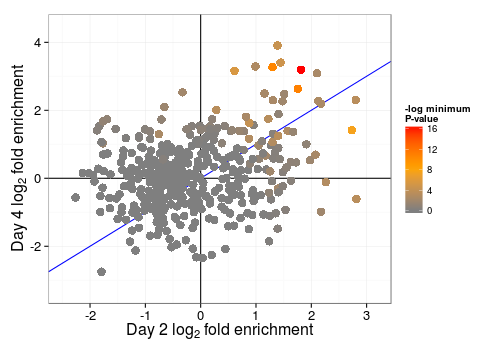

In [33]:
%%R -w 500 -h 350
d = read.csv("../data/l2fc_table.csv", stringsAsFactors = FALSE) %>%
    filter(test == "greater") %>%
    group_by(OTU) %>%
    mutate(min.p = min(p.adj, na.rm = TRUE)) %>%
    select(OTU, min.p, Rank2, day, log2FoldChange) %>%
    spread(day, log2FoldChange)

p = ggplot(d, aes(x = `2`, y = `4`, color = -log(min.p)))

p = p + geom_hline(xintercept = 0)

p = p + geom_vline(yintercept = 0)

p = p + geom_abline(slope = 1, color = "blue")

p = p + geom_point(size = 4)

p = p + scale_colour_gradientn(colours = c("grey50", "orange", "red"))

p = p + labs(x = expression(paste("Day 2 ", log[2], " fold", " enrichment", sep = "")), 
             y = expression(paste("Day 4 ", log[2], " fold", " enrichment", sep = "")), 
             color = "-log minimum\nP-value")

p = p + theme_bw()

p = p + theme(axis.text = element_text(size = 13),
              axis.title = element_text(size = 16))

p

In [34]:
%%R
ggsave("figs/2v4l2fc.pdf", p, h = 5, w = 7)

In [35]:
FileLink("figs/2v4l2fc.pdf")

/home/chuck/working/NSIP_data_analysis/figures_and_stats/figs/2v4l2fc.pdf

In [37]:
%%R
summary(lm(`2` ~ `4`, data = d))


Call:
lm(formula = `2` ~ `4`, data = d)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0511 -0.6284 -0.1182  0.6413  3.1395 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.17352    0.04647  -3.734 0.000215 ***
`4`          0.24941    0.04468   5.582 4.35e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9295 on 405 degrees of freedom
  (248 observations deleted due to missingness)
Multiple R-squared:  0.07145,	Adjusted R-squared:  0.06916 
F-statistic: 31.16 on 1 and 405 DF,  p-value: 4.351e-08



In [123]:
%%R
read.csv("../data/l2fc_table.csv", stringsAsFactors = FALSE) %>%
    filter(OTU %in% rspndrs, test == "greater") %>%
    select(OTU, Rank2, day, log2FoldChange) %>%
    filter(log2FoldChange < 0)

       OTU          Rank2 day log2FoldChange
1  OTU.137 Proteobacteria   2     -0.7568935
2  OTU.227     Firmicutes   4     -0.6103456
3 OTU.4037     Firmicutes   4     -0.1137922


In [118]:
%%R
otus = read.csv("../data/l2fc_table.csv", stringsAsFactors = FALSE) %>%
    select(OTU) %>% extract2(1) %>% unique

physeq = import_biom("../data/otu_table_wtax.biom")
md = read.table("../data/barcoiikkkkkkkde_mapper.txt", 
                sep = "\t", 
                header = TRUE,
                comment = "")
rownames(md) = md$X.SampleID
md$DayCollected %<>% factor
sample_data(physeq) = sample_data(md)
sd = sample_data(physeq)

density.min = 1.725

physeq = prune_samples(sd$Density >= density.min, physeq)

TT = data.frame(tax_table(physeq))
TT$OTU = rownames(TT)

physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4340 taxa and 36 samples ]
sample_data() Sample Data:       [ 36 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 4340 taxa by 8 taxonomic ranks ]


In [98]:
%%R
dds = phyloseq_to_deseq2(physeq, ~Treatment*factor(DayCollected))
dds = DESeq(dds)
res.int = data.frame(results(dds, independentFiltering = FALSE, cooksCutoff = FALSE))
res.int$OTU = rownames(res)

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
NOTE: fitType='parametric', but the dispersion trend was not well captured by the
  function: y = a/x + b, and a local regression fit was automatically substituted.
  specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 2 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


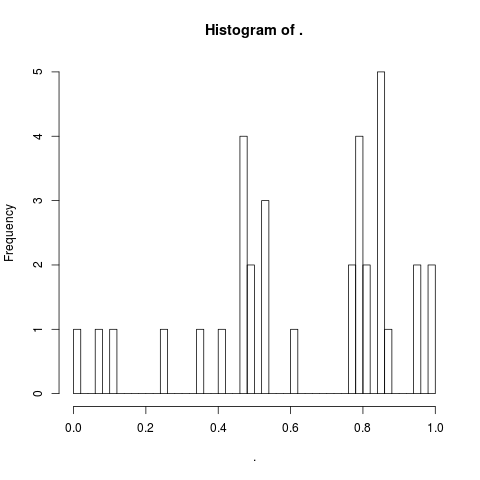

In [99]:
%%R
res.int %>%
    filter(OTU %in% otus) %>%
    mutate(p.adj = p.adjust(pvalue, method = "BH")) %>%
    filter(OTU %in% rspndrs) %>%
    select(p.adj) %>% extract2(1) %>% hist(breaks = 50)

In [121]:
%%R
FDR = 0.10

res.int %>%
    filter(OTU %in% otus) %>%
    left_join(TT) %>%
    mutate(p.adj = p.adjust(pvalue, method = "BH")) %>%
    filter(OTU %in% rspndrs) %>% 
    select(OTU, p.adj, Rank2, Rank3) %>%
    filter(p.adj <= FDR)

Joining by: "OTU"
       OTU      p.adj      Rank2      Rank3
1  OTU.227 0.01600450 Firmicutes Clostridia
2 OTU.4037 0.06604938 Firmicutes Clostridia


In [100]:
%%R
dds = phyloseq_to_deseq2(physeq, ~Treatment)
dds = DESeq(dds)
res = data.frame(results(dds, independentFiltering = FALSE, cooksCutoff = FALSE))
res$OTU = rownames(res)

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
NOTE: fitType='parametric', but the dispersion trend was not well captured by the
  function: y = a/x + b, and a local regression fit was automatically substituted.
  specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 29 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [127]:
%%R
FDR = 0.10
l2fc.threshold = 0.25

TT = data.frame(tax_table(physeq))
TT$OTU = rownames(TT)

res %>%
    filter(OTU %in% otus) %>%
    mutate(p = pnorm(log2FoldChange, l2fc.threshold, lfcSE, lower.tail = FALSE)) %>%
    left_join(TT) %>%
    mutate(p.adj = p.adjust(p, method = "BH")) %>%
    filter(OTU %in% rspndrs) %>%
    select(OTU, p.adj, Rank2, Rank3) %>%
    filter(p.adj > FDR)

Joining by: "OTU"
       OTU     p.adj          Rank2               Rank3
1  OTU.140 0.1216431     Firmicutes             Bacilli
2  OTU.137 0.5017051 Proteobacteria Alphaproteobacteria
3  OTU.227 1.0000000     Firmicutes          Clostridia
4 OTU.4037 0.1102896     Firmicutes          Clostridia
5  OTU.263 0.2790517 Proteobacteria Alphaproteobacteria
